In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/yuncong/Brain/pipeline_scripts')
from utilities2014 import *
import os

os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/project/DavidData2014results/'
os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from networkx import floyd_warshall, Graph, connected_components, find_cliques, from_numpy_matrix
from itertools import product
from collections import defaultdict

In [5]:
stack_name = 'RS140'

In [6]:
dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=7)
m = dm.load_pipeline_result('matchings%dWith%d'%(7, 8), 'pkl')
d = dm.load_pipeline_result('DBoundaries%dWith%d'%(7, 8), 'npy')
d_shape = dm.load_pipeline_result('D3s%dWith%d'%(7, 8), 'npy')

In [9]:
print get_relaxed_matches(d)

[(1, 2), (1, 0), (1, 11), (2, 25), (2, 11), (3, 17), (3, 26), (3, 25), (4, 10), (6, 22), (7, 18), (8, 16), (8, 21), (8, 10), (11, 3), (13, 28), (13, 24), (13, 23), (14, 17), (14, 19), (16, 3), (17, 23), (19, 3), (20, 9), (20, 19), (22, 5), (22, 27), (23, 25), (23, 6), (24, 17), (24, 18), (24, 2), (25, 27), (26, 9), (27, 20), (28, 23), (28, 28), (30, 2)]


In [8]:
def get_relaxed_matches(D, dist_percent_thresh=.2):
    nns1 = D.argsort(axis=1)[:,:3]
    nns2 = D.argsort(axis=0)[:3,:].T

    dd = D[D!=np.inf]
    th = np.sort(dd)[int(dist_percent_thresh*len(dd))]

    relaxed_matches = [(i,n) for i, nns in enumerate(nns1) for n in nns if i in nns2[n] and D[i,n] < th]

    return relaxed_matches

In [49]:
from subprocess import check_output
s = check_output("ssh gordon.sdsc.edu ls %s" % os.path.join(os.environ['GORDON_DATA_DIR'], stack_name, 'x5'), shell=True)
slide_indices = [int(f) for f in s.split('\n') if len(f) > 0]
n_slice = len(slide_indices)
last_sec = max(slide_indices)

In [50]:
G = Graph()

for sec1 in slide_indices:
    dm1 = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec1)
    
    if sec1 < last_sec:
        matchings = dm1.load_pipeline_result('matchings%dWith%d'%(sec1, sec1+1), 'pkl')
        for s,i,j in matchings:
            G.add_edge((sec1,i),(sec1+1,j))

    if sec1 < last_sec-1:
        matchings = dm1.load_pipeline_result('matchings%dWith%d'%(sec1, sec1+2), 'pkl')
        for s,i,j in matchings:
            G.add_edge((sec1,i),(sec1+2,j))
    
    if sec1 < last_sec-2:
        matchings = dm1.load_pipeline_result('matchings%dWith%d'%(sec1, sec1+3), 'pkl')
        for s,i,j in matchings:
            G.add_edge((sec1,i),(sec1+3,j))

In [908]:
G = Graph()

th = .2

for sec1 in range(0,29):
    dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec1)
    
    D = dm.load_pipeline_result('DBoundaries%dWith%d'%(sec1, sec1+1), 'npy')
    relaxed_matches = get_relaxed_matches(D, th)
    
    for i,j in relaxed_matches:
        G.add_edge((sec1,i),(sec1+1,j))

    if sec1 < 28:
        D = dm.load_pipeline_result('DBoundaries%dWith%d'%(sec1, sec1+2), 'npy')
         
        relaxed_matches = get_relaxed_matches(D, th)
        
        for i,j in relaxed_matches:
            G.add_edge((sec1,i),(sec1+2,j))
    
    if sec1 < 27:
        D = dm.load_pipeline_result('DBoundaries%dWith%d'%(sec1, sec1+3), 'npy')
        
        relaxed_matches = get_relaxed_matches(D, th)
        
        for i,j in relaxed_matches:
            G.add_edge((sec1,i),(sec1+3,j))
            

In [51]:
from networkx import draw_networkx, k_clique_communities

pos = {}
for s,l in G.node:
    pos[(s,l)] = (s,l)

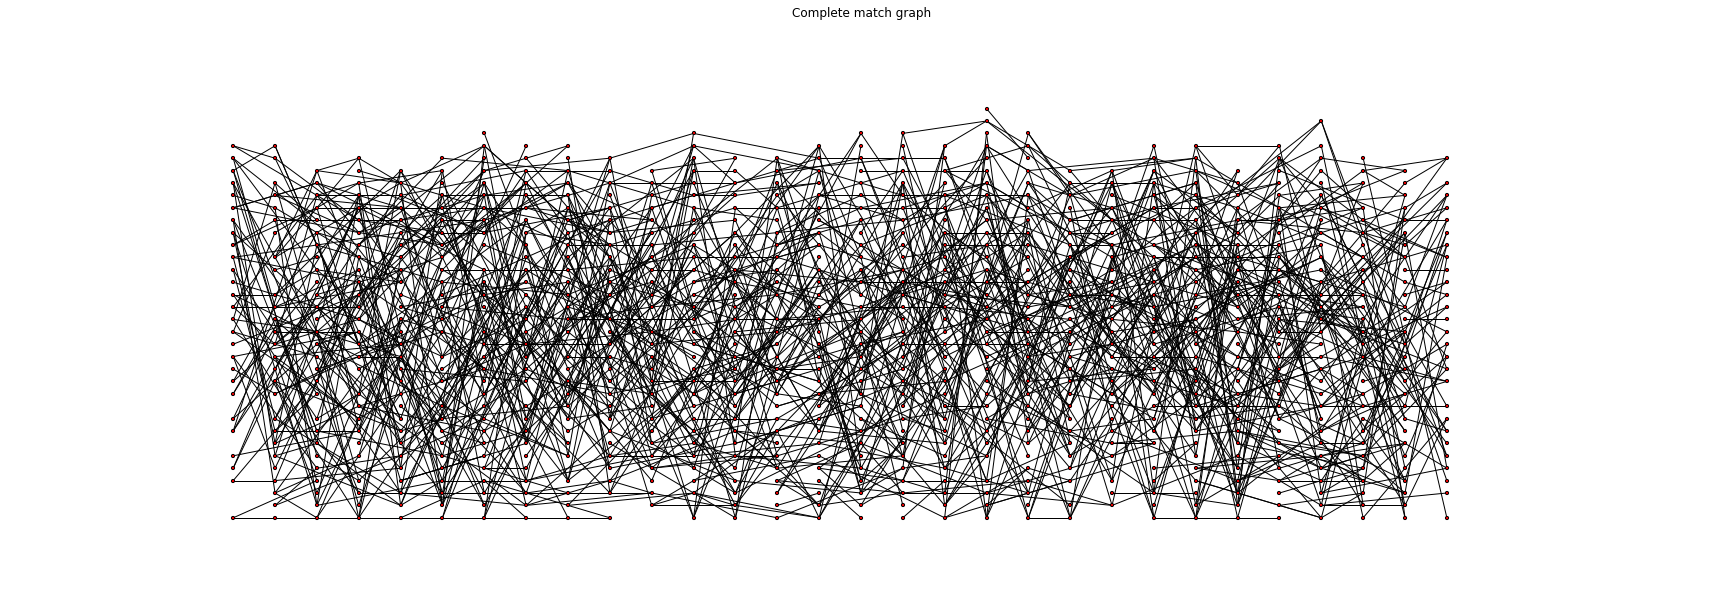

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(30,10));
plt.axis('off');
plt.title('Complete match graph');
# draw_networkx(G, pos, node_size=10, with_labels=False, edgelist=[]);
draw_networkx(G, pos, node_size=10, with_labels=False);

In [52]:
from scipy.cluster.hierarchy import average, fcluster, single, complete, weighted
from scipy.spatial.distance import cdist, pdist, squareform

def group_clusters(distance_matrix, dist_thresh = 0.1):

    lk = single(squareform(distance_matrix))
#     lk = average(squareform(distance_matrix))
#     lk = complete(squareform(distance_matrix))

    T = fcluster(lk, dist_thresh, criterion='distance')
    
    n_groups = len(set(T))    
    groups = [None] * n_groups

    for group_id in range(n_groups):
        groups[group_id] = np.where(T == group_id+1)[0]
        
    return [g for g in groups if len(g) > 0]

In [83]:
node = (12,25)

[(9, 22), (11, 0), (12, 25), (13, 22), (14, 25), (15, 25)]

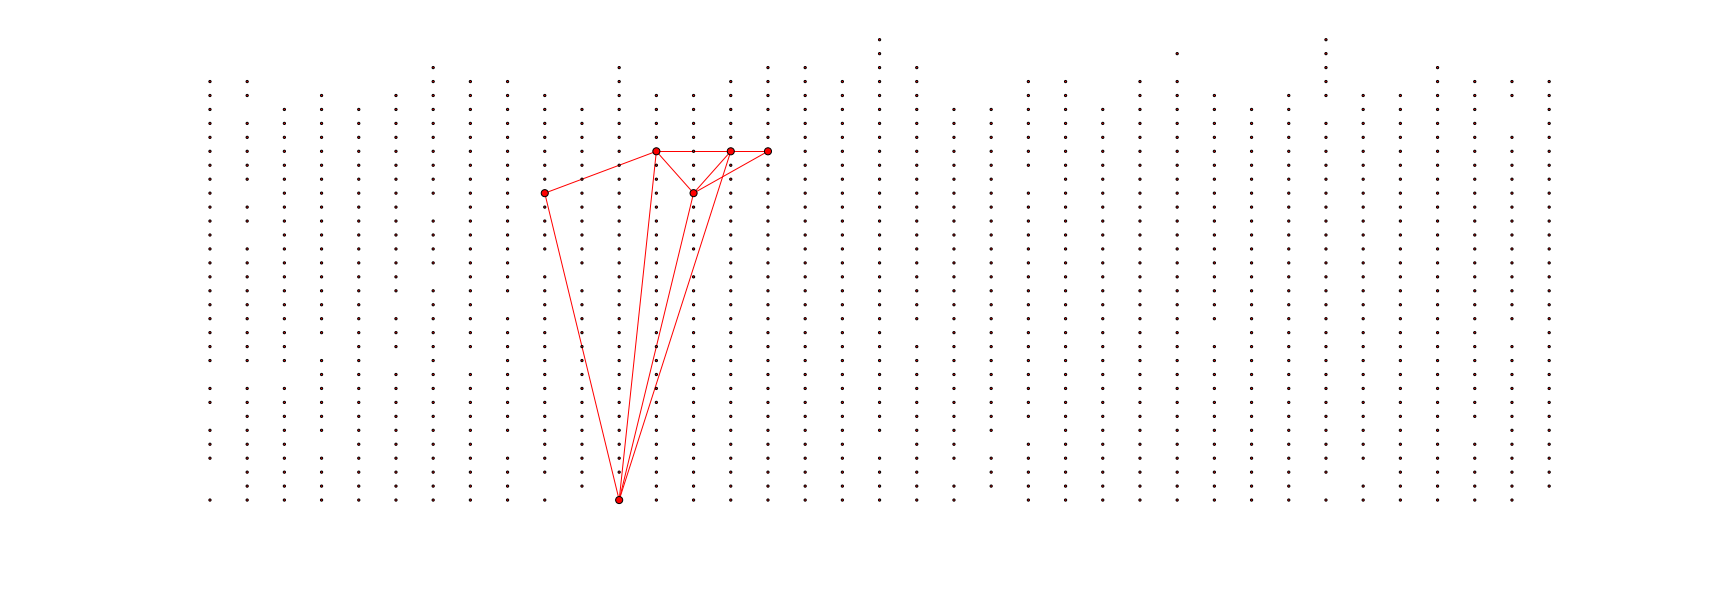

In [84]:
draw_group_containing_node(node, [set(G.neighbors(node)) | {node}])

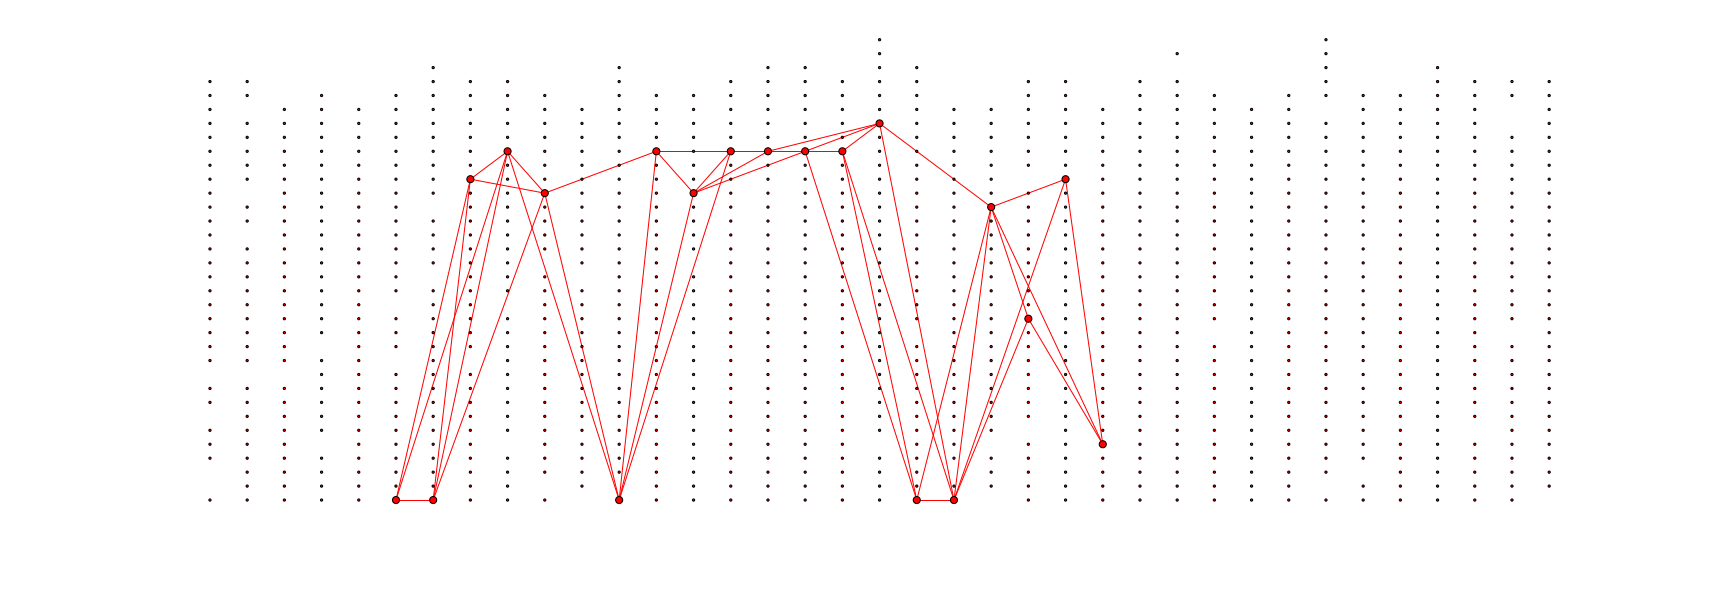

In [88]:
# cliques = sorted([sorted(cl) for cl in find_cliques(G) if len(cl)>=3], key=len, reverse=True)
# cliques = [set(cl)for cl in find_cliques(G) if len(cl) == 4]
cliques = [set(cl)for cl in find_cliques(G) if len(cl) >= 3]
overlap_mat = np.reshape([len(i & j) for i,j in product(cliques,cliques)], (len(cliques),len(cliques)))

m = overlap_mat.max()
d = m - overlap_mat
np.fill_diagonal(d, 0)

# node_groups = list(k_clique_communities(G, 4))
# draw_group_containing_node(node, node_groups)

overlap_thresh = 2
node_groups = sorted([sorted(list(set(sum([list(cliques[i]) for i in g], [])))) 
               for g in group_clusters(d, m-overlap_thresh)], 
                     key=len, reverse=True)

h = draw_group_containing_node(node, node_groups)

# overlap_thresh = 1
# node_groups = sorted([sorted(list(set(sum([list(cliques[i]) for i in g], [])))) 
#                for g in group_clusters(d, m-overlap_thresh)], 
#                      key=len, reverse=True)

# h = draw_group_containing_node(node, node_groups)

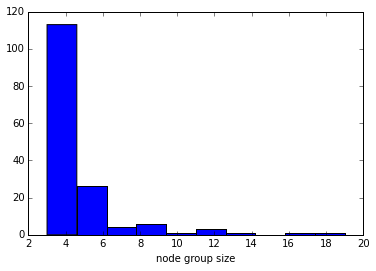

In [89]:
plt.hist([len(g) for g in node_groups if len(g) >= 2]);
plt.xlabel('node group size');
plt.show();

[(11, 0), (12, 25), (13, 22), (14, 25)]

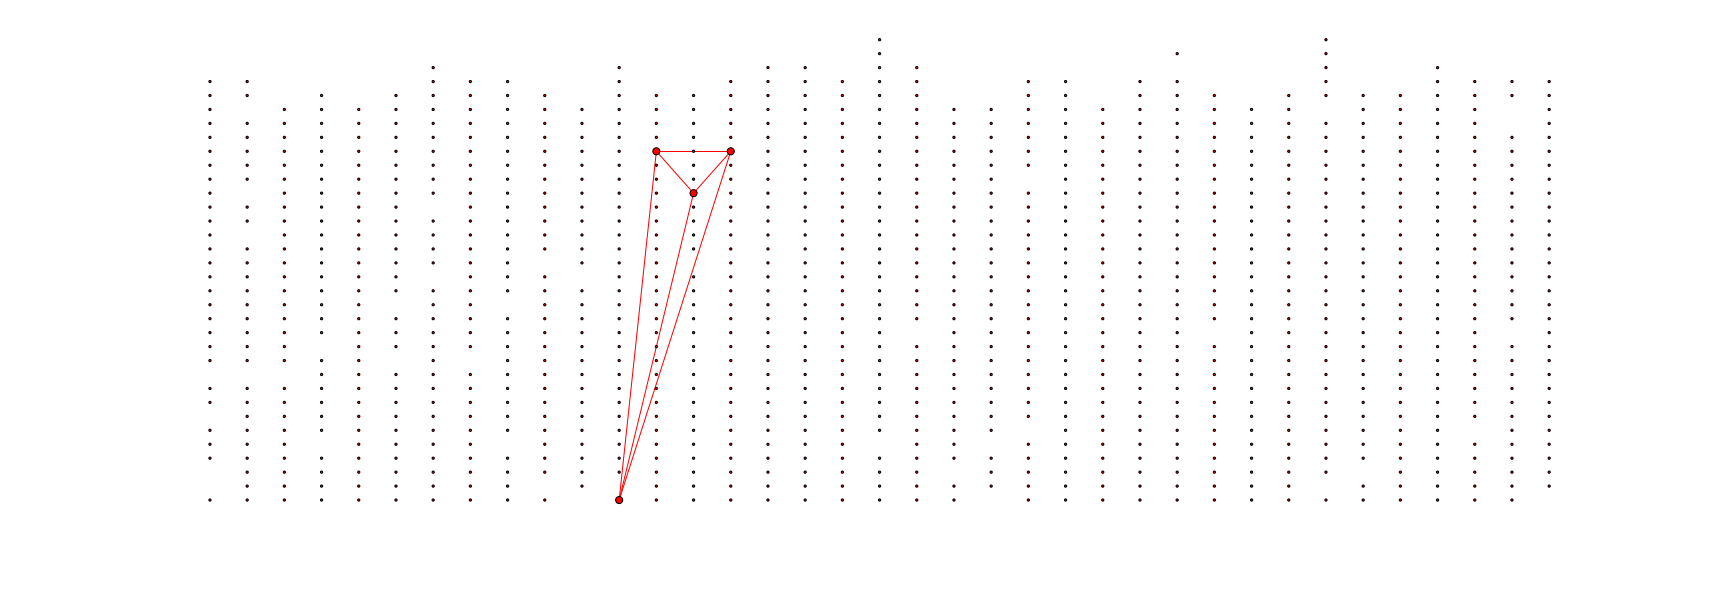

In [90]:
draw_group_containing_node(node, cliques)

In [963]:
from joblib import Parallel, delayed
from skimage.transform import resize

def f(i, lms):
    v = visualize_landmark_multiple_sections(lms, text=True)
    try:
        imsave('/tmp/robustLandmark%d.jpg'%i, v)
    except IOError as e:
        imsave('/tmp/robustLandmark%d.jpg'%i, resize(v, (v.shape[0]/2,v.shape[1]/2)))
        
Parallel(n_jobs=16)(delayed(f)(i, lms) for i, lms in enumerate(consistent_robust_lms))

array([ 0,  5, 10, 15, 20, 25])

In [43]:
from skimage.util import pad

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

def visualize_landmark_multiple_sections2(tpl, text=False):
    '''
    e.g. tpl = [(3,1),(4,2)]
    '''
    
    viss = []
    for sec, bnd in tpl: 
        dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec)
        v = dm.load_pipeline_result('boundary%02d'%bnd, 'jpg')
        if text:
            cv2.putText(v, '%d,%d'%(sec,bnd), tuple([300,300]), cv2.FONT_HERSHEY_COMPLEX, 10, (0,0,0), 5)
        viss.append(v)
    
    hws = np.array([v.shape[:2] for v in viss])
    hmax, wmax = np.max(hws, axis=0)
    top_margins = [int((hmax - h)/2) for h,w in hws]
    bottom_margins = [ hmax - h - lm for (h,w), lm in zip(hws, top_margins)]
    
    viss_padded = []
    for vis, lm, rm in zip(viss, top_margins, bottom_margins):
        viss_padded.append(pad(vis, ((lm,rm),(0,0),(0,0)), 'constant', constant_values=255))
        
    vis_stacked = np.hstack(viss_padded)
    return vis_stacked

In [92]:
node_groups[1]

[(10, 22),
 (12, 0),
 (13, 23),
 (14, 26),
 (15, 26),
 (16, 24),
 (17, 26),
 (18, 0),
 (19, 26),
 (20, 22),
 (21, 22),
 (22, 0),
 (23, 0),
 (24, 24),
 (25, 24),
 (26, 29),
 (28, 28)]

In [44]:
from joblib import Parallel, delayed
from skimage.transform import resize

def f(i, h):
    row_size = 5
    for r in np.arange(0, len(h), row_size):
        v = visualize_landmark_multiple_sections2(h[r:r+row_size], text=True)
        imsave('/tmp/robustLandmark%d_%d.jpg'%(i, r/row_size), resize(v, (v.shape[0]/5,v.shape[1]/5)))
        
Parallel(n_jobs=16)(delayed(f)(i, lms) for i, lms in enumerate(node_groups[:10]))  

[None, None, None, None, None, None, None, None, None, None]

In [786]:
n_nodes = G.number_of_nodes()
connection_features = [set(G.neighbors(n)) | {n} for n in G.nodes_iter()]
overlap_mat = np.reshape([len(i&j)
                          for i,j in product(connection_features,connection_features)], 
                         (n_nodes,n_nodes))
m = overlap_mat.max()
d = m - overlap_mat
np.fill_diagonal(d, 0)

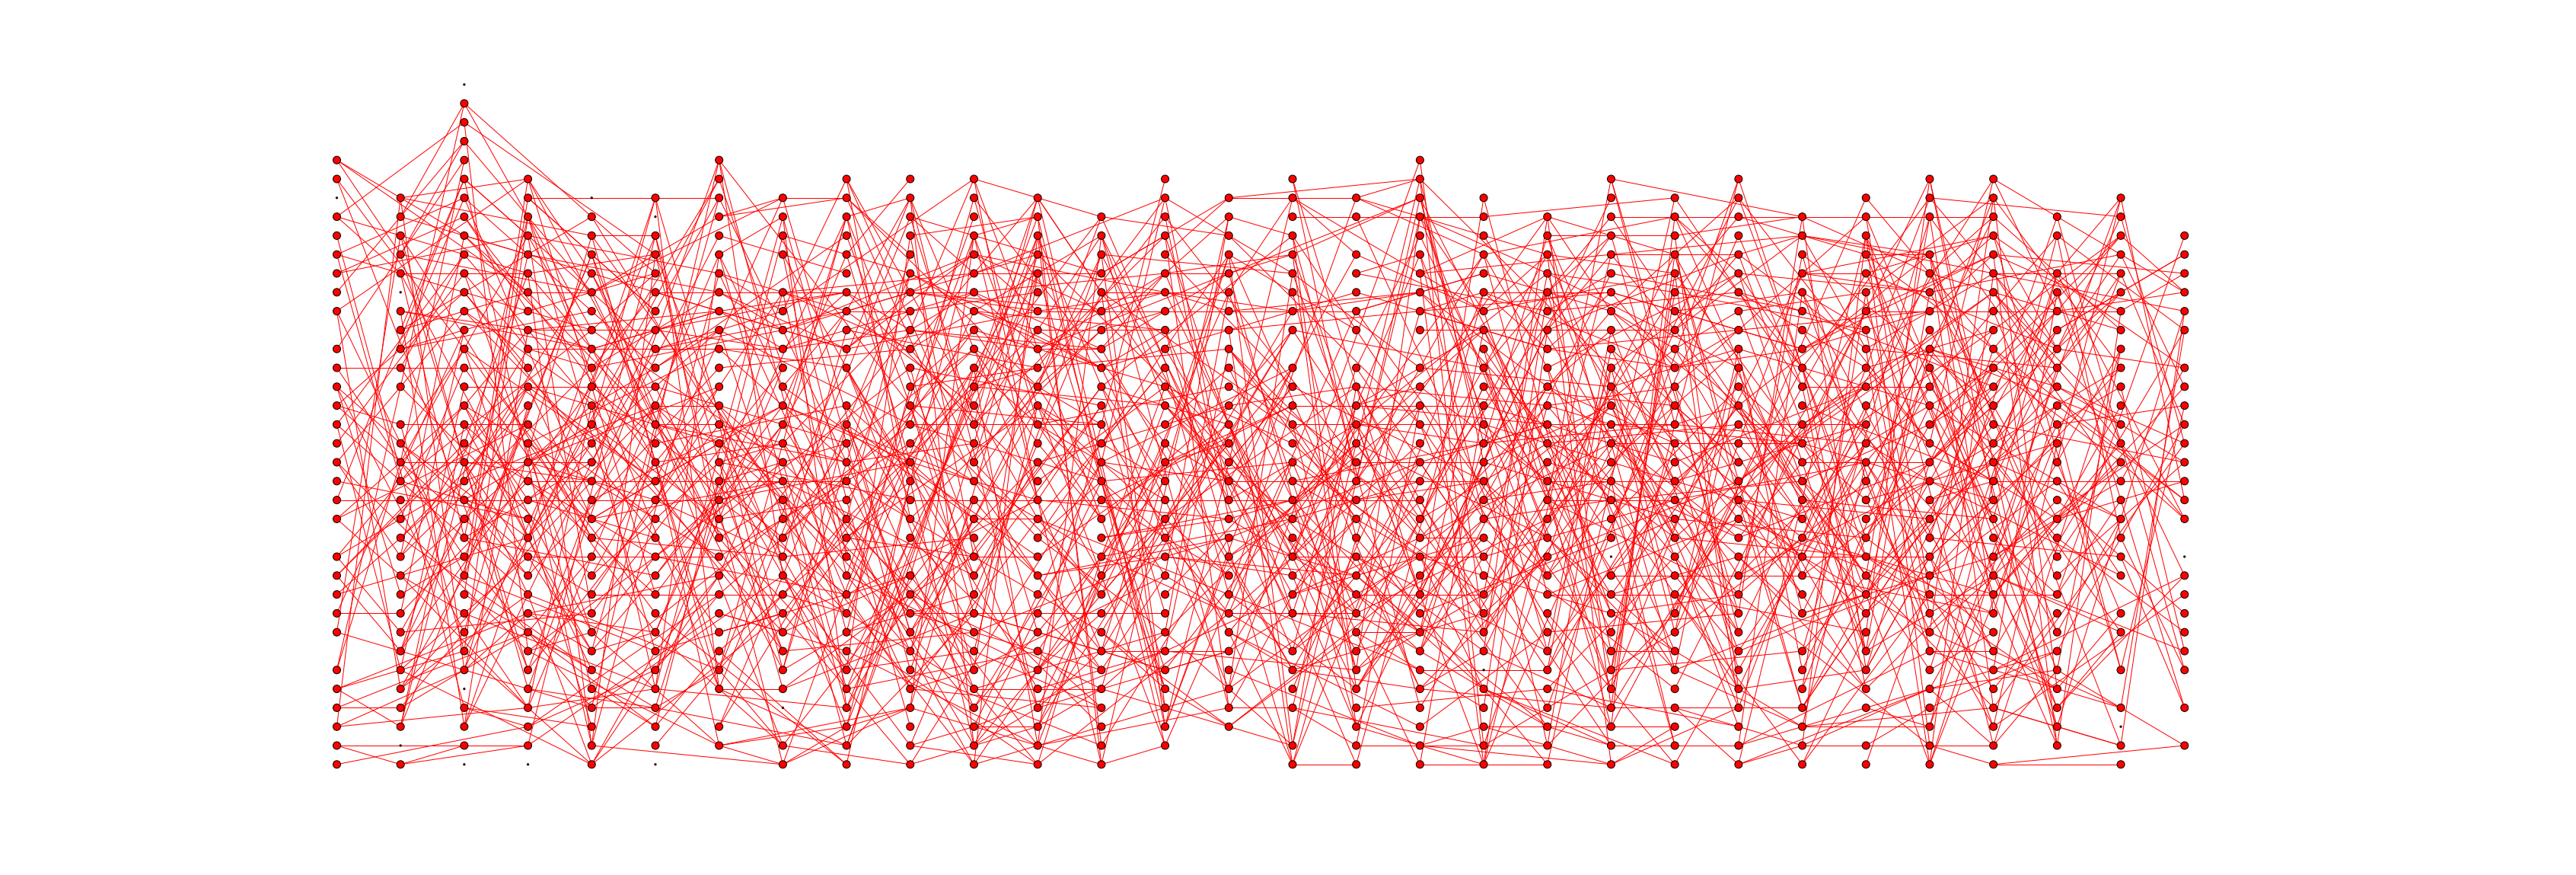

In [788]:
overlap_thresh = 1
node_groups = sorted([sorted([G.nodes()[n] for n in g]) 
                      for g in group_clusters(d, m-overlap_thresh)],
                     key=lambda x: len(x), reverse=True)
draw_group_containing_node(node, node_groups)

In [892]:
n_nodes = G.number_of_nodes()
connection_features = [set(G.neighbors(n)) | {n} for n in G.nodes_iter()]

jaccard_mat = np.zeros((n_nodes,n_nodes))
for i, (si, li) in enumerate(G.nodes_iter()):
    for j, (sj, lj) in enumerate(G.nodes_iter()):
        a = set([(sn,ln) for sn,ln in connection_features[i] if sn >= sj-3 and sn <= sj+3])
        b = set([(sn,ln) for sn,ln in connection_features[j] if sn >= si-3 and sn <= si+3])
        if len(a)==0 or len(b)==0:
            jaccard_mat[i,j] = 0
        else:
            jaccard_mat[i,j] = len(a&b)/float(len(a|b))

            
# jaccard_mat = np.reshape([len(i&j)/float(len(i|j)) 
#                           for i,j in product(connection_features,connection_features)], 
#                          (n_nodes,n_nodes))

In [ ]:
jaccard_thresh = .5
node_groups = sorted([sorted([G.nodes()[n] for n in g]) for g in group_clusters(1.-jaccard_mat, 1.-jaccard_thresh)],
                    key=lambda x: len(x), reverse=True)
draw_group_containing_node(node, node_groups)

jaccard_thresh = .6
node_groups = sorted([sorted([G.nodes()[n] for n in g]) for g in group_clusters(1.-jaccard_mat, 1.-jaccard_thresh)],
                    key=lambda x: len(x), reverse=True)
draw_group_containing_node(node, node_groups)

jaccard_thresh = .7
node_groups = sorted([sorted([G.nodes()[n] for n in g]) for g in group_clusters(1.-jaccard_mat, 1.-jaccard_thresh)],
                    key=lambda x: len(x), reverse=True)
draw_group_containing_node(node, node_groups)


node_groups = list(k_clique_communities(G, 4))
draw_group_containing_node(node, node_groups)


In [18]:
def draw_group_containing_node(node, node_groups):
        
    group_lookup = defaultdict(set)
    for gi, g in enumerate(node_groups):
        for n in g:
            group_lookup[n].add(gi)
    
    group_ind = list(group_lookup[node])[0]
        
    fig = plt.figure(figsize=(30,10));
    plt.axis('off');

    # draw_networkx(G, pos, node_size=10, with_labels=False)
    # plt.savefig('/tmp/match_graph_relaxed.png', bbox_inches='tight')

    # draw_networkx(G, pos, node_size=10, with_labels=False, edge_color=colors)

    selected_edges = [(i,j) for i,j in G.edges_iter() 
                      if i in group_lookup and j in group_lookup and group_ind in group_lookup[i]
                     and group_ind in group_lookup[j]]
        
#     selected_colors = [all_colors[group_lookup[i]%len(all_colors)] for i,j in G.edges_iter() 
#                        if i in group_lookup and j in group_lookup and group_lookup[i] == group_ind]
    
#     selected_nodes = set([i for e in selected_edges for i in e ]) | set(node_groups[group_ind])
    selected_nodes = set([i for e in selected_edges for i in e ])
    node_size = [50 if n in selected_nodes else 5 for n in G.nodes_iter()]

    draw_networkx(G, pos, with_labels=False, edgelist=selected_edges, edge_color='r',
                 node_size=node_size)
    # plt.savefig('/tmp/clique_groups_relaxed.png', bbox_inches='tight')
    
    return sorted(list(selected_nodes))
            

In [693]:
all_matchings = G.edges()

for i in all_matchings:
    if (2, 31) in i:
        print i

((0, 14), (2, 31))
((4, 7), (2, 31))
((5, 27), (2, 31))
((4, 1), (2, 31))
((4, 10), (2, 31))
((5, 11), (2, 31))
((3, 28), (2, 31))
((1, 20), (2, 31))
((0, 29), (2, 31))
((2, 31), (1, 23))
((2, 31), (5, 22))


In [72]:
from joblib import Parallel, delayed
from skimage.transform import resize

def f(i, lms):
    v = visualize_landmark_multiple_sections(lms, text=True)
    try:
        imsave('/tmp/robustLandmark%d.jpg'%i, v)
    except IOError as e:
        imsave('/tmp/robustLandmark%d.jpg'%i, resize(v, (v.shape[0]/2,v.shape[1]/2)))
        

Parallel(n_jobs=16)(delayed(f)(i, lms) for i, lms in enumerate(consistent_robust_lms))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [60]:
display(visualize_landmark_multiple_sections(robust_lms[5], text=True))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [38]:
display(visualize_multiple_landmarks_multiple_sections({2:[15], 3:[20]}))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [42]:
def visualize_multiple_landmarks_multiple_sections2(d):
    '''
    e.g. tpl = {3:[2,5,12], 4:[6,4,2]}
    '''
    
    viss = []
    for sec, bnds in d.iteritems():
        dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec)
        boundaries = dm.load_pipeline_result('boundaryModels', 'pkl')
        viss.append(dm.visualize_edge_sets([boundaries[b][0] for b in bnds], text=False))
    
    hws = np.array([v.shape[:2] for v in viss])
    hmax, wmax = np.max(hws, axis=0)
    top_margins = [int((hmax - h)/2) for h,w in hws]
    bottom_margins = [ hmax - h - lm for (h,w), lm in zip(hws, top_margins)]
    
    viss_padded = []
    for vis, lm, rm in zip(viss, top_margins, bottom_margins):
        viss_padded.append(pad(vis, ((lm,rm),(0,0),(0,0)), 'constant', constant_values=255))
        
    vis_stacked = np.hstack(viss_padded)
    return vis_stacked

In [881]:
def visualize_multiple_landmarks_multiple_sections(d):
    '''
    e.g. tpl = {3:[2,5,12], 4:[6,4,2]}
    '''
    
    viss = []
    for sec, bnds in d.iteritems():
        dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec)
        boundaries = dm.load_pipeline_result('boundaryModels', 'pkl')
        viss.append(dm.visualize_edge_sets([boundaries[b][0] for b in bnds], text=False))
    
    hws = np.array([v.shape[:2] for v in viss])
    hmax, wmax = np.max(hws, axis=0)
    left_margins = [int((wmax - w)/2) for h,w in hws]
    right_margins = [ wmax - w - lm for (h,w), lm in zip(hws, left_margins)]
    
    viss_padded = []
    for vis, lm, rm in zip(viss, left_margins, right_margins):
        viss_padded.append(pad(vis, ((0,0),(lm,rm),(0,0)), 'constant', constant_values=255))
        
    vis_stacked = np.vstack(viss_padded)
    return vis_stacked

In [882]:
from skimage.util import pad

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

def visualize_landmark_multiple_sections(tpl, text=False):
    '''
    e.g. tpl = [(3,1),(4,2)]
    '''
    
    viss = []
    for sec, bnd in tpl: 
        dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec)
        v = dm.load_pipeline_result('boundary%02d'%bnd, 'jpg')
        if text:
            cv2.putText(v, '%d,%d'%(sec,bnd), tuple([300,300]), cv2.FONT_HERSHEY_COMPLEX, 10, (0,0,0), 5)
        viss.append(v)
    
    hws = np.array([v.shape[:2] for v in viss])
    hmax, wmax = np.max(hws, axis=0)
    left_margins = [int((wmax - w)/2) for h,w in hws]
    right_margins = [ wmax - w - lm for (h,w), lm in zip(hws, left_margins)]
    
    viss_padded = []
    for vis, lm, rm in zip(viss, left_margins, right_margins):
        viss_padded.append(pad(vis, ((0,0),(lm,rm),(0,0)), 'constant', constant_values=255))
        
    vis_stacked = np.vstack(viss_padded)
    return vis_stacked